# Get and interpret meetup data

My goal was to prep for the [DuPage Python metup](https://www.meetup.com/DuPage-Python-Meetup/) by knowing my audience, to tailor my talk to their interests, so this notebook pulls the group members' other memberships (R? Data Science? Android?) to use as a proxy for topics of interest. (Even though there's a "topics" category for each profile in the meetup data...guess I was curious who might be in other meetups I go to.)

- You will need a Meetup account to run the workbook because it requires a (free) API key.
- If  this weirds you out you can always [hide the groups on your profile](https://help.meetup.com/hc/en-us/articles/360002862392-Hiding-my-list-of-Meetup-Groups-on-my-profile).

## Setup

In [0]:
!pip install --quiet upsetplot

import json
import os
import statistics
import time

import pandas
import requests
# Here is the R version of upsetplot (from the original authors)
#   https://cran.r-project.org/web/packages/UpSetR/vignettes/basic.usage.html
import upsetplot
from collections import Counter, defaultdict

In [3]:
import getpass
print("Go to https://secure.meetup.com/meetup_api/key/ for your API key.")
apikey = getpass.getpass(prompt="meetup api key: ")

Go to https://secure.meetup.com/meetup_api/key/ for your API key.
meetup api key: ··········


## Data acquisition

Meetup's API documentation is [here](https://www.meetup.com/meetup_api/). They will throttle your requests if you make more than 30 per unit of time, so you have to sleep in between requests. I don't know the time scale but assumed it was per minute. (So this takes about 5 minutes with ~150 members).

In [0]:
# Meetup api documentation: https://www.meetup.com/meetup_api/
import time
api_url = "https://api.meetup.com"

group = "DuPage-Python-Meetup"
response = requests.get(f"{api_url}/{group}/members")
user_ids = [entry["id"] for entry in response.json()]

all_users_groups = {}
for user_id in user_ids:
    time.sleep(3)  # Meetup throttles you
    result = requests.get(f"{api_url}/members/{user_id}?sign=True&key={apikey}&fields=memberships").json()
    if "memberships" not in result:
        all_users_groups[user_id] = []
    else:
        group_names = sorted(m["group"]["name"] for m in result["memberships"]["member"])
        all_users_groups[user_id] = group_names

#### Here's the rate limit I was telling you about

In [5]:
response.headers["X-RateLimit-Limit"]

'30'

## Analysis
Just basic counts here.

In [6]:
print(f"total people is: {len(all_users_groups)}")
group_counts = [len(groups) for groups in all_users_groups.values()]
print("Other group membership stats:")
print(f"- average: {statistics.mean(group_counts):.0f}")
print(f"- median: {statistics.median(group_counts):.0f}")
print(f"- max: {max(group_counts)}; min: {min(group_counts)}")

#from google.colab import files
#filename = 'all_users_groups.json'
#with open(filename, 'w') as f:
#  f.write(json.dumps(all_users_groups))
#
#files.download(filename)

total people is: 147
Other group membership stats:
- average: 19
- median: 10
- max: 205; min: 0


Use the standard library `collections`'  `Counter` to identify the most popular groups.

In [7]:
all_groups = Counter()
for groups in all_users_groups.values():
    all_groups.update(groups)
print(f"Total users: {len(user_ids)}")
total_users_who_shared_their_group = len([g for g in all_users_groups.values() if g])
print(f"Total groups: {len(all_groups)} ({total_users_who_shared_their_group} users shared their groups)")
print(f"\nMost common groups:\n{'-' * 19}")
for name, count in all_groups.most_common(10):
    print(f"  {name}: {count}")

Total users: 147
Total groups: 1231 (130 users shared their groups)

Most common groups:
-------------------
  DuPage Python Meetup: 129
  ChiPy: Chicago's Official Python User Group: 34
  OpenHack Naperville: 27
  DuPage R Meetup: 27
  PyData Chicago: 24
  Metis: Chicago Data Science: 23
  DuPage Business Analytics Meetup: 22
  Naperville Software Development Meetup: 20
  Chicago R User Group (CRUG) Data and Statistical Programming: 19
  Fox_Py    Python meetup in St Charles and Fox Valley.: 19


### Extracting relevant data

Following the advice in the Python tutorial about [using an empty class instance to hold related names](https://docs.python.org/3/tutorial/classes.html#odds-and-ends), this section extracts various terms from the dataset and groups them together. The resulting printout shows all the categorized groups.

In [8]:
most_common_groups = set(name for name, count in all_groups.most_common(150))


class Namespace:
    pass


def filter_for(*terms, source=most_common_groups):
    return set(g for g in source if any(term in g.lower() for term in terms))

groups = Namespace()

groups.python = filter_for("python", "pydata", "pyladies")
groups.r = filter_for(" r ", "r-ladies")
groups.infrastructure = filter_for("aws", "azure", "cloud", "devops", "sql", "hadoop", "kube")
groups.js_frontend = filter_for("angular", "front", "html", "javascript", "js", "react", "web")
groups.hot_new = filter_for("autonomous", "blockchain", "crypto", "iot")
groups.maker = filter_for("hackerspace", "maker", "pumping", "raspberry pi")
groups.other_languages = filter_for(".net", "c++", "java ", "ruby", "scala")
groups.data_science = filter_for(
    "analy", "data an", "data sc", "deep learn", "intelligence",
    "machine learn", "ml", "quant", "statistics", "tensorflow", "time series")

remaining = most_common_groups.copy()
for group in groups.__dict__.values():
    remaining.difference_update(group)


# Only include things in "business" that aren't already categorized
groups.business = filter_for(
    "business", "entrepreneur", "fund", "invest", "leader", "professional", "startup",
    source=remaining
)
remaining.difference_update(groups.business)

# Only include things in "general" that aren't already categorized
groups.general = filter_for(
    "acm", "agile", "code", "coding", "comput", "dev", "develop",
    "geekfest", "hack", "linux", "open source", "software", "tech",
    source=remaining
)
remaining.difference_update(groups.general)


# Summarize results
groups.uncategorized = remaining
print(f"{len(groups.uncategorized)} remaining uncategorized")
newline = "\n"

for groupname, values in groups.__dict__.items():
    print(f"\n\n{'-'*len(groupname)}\n{groupname}\n{'-'*len(groupname)}\n{newline.join(sorted(values))}")

37 remaining uncategorized


------
python
------
ChiPy: Chicago's Official Python User Group
Chicago PyLadies
Chicago Python Meetup • ProgramWithUs.com
Chicago Pythonistas
Data Science and Python
DuPage Python Meetup
Fox Valley Python
Fox_Py    Python meetup in St Charles and Fox Valley.
PyData Chicago


-
r
-
Chicago R User Group (CRUG) Data and Statistical Programming
Data Analytics and R - Chicago Northwest Suburbs
DuPage R Meetup


--------------
infrastructure
--------------
AWS Chicago
AWS Chicago Suburbs
Aurora Naperville all things Azure, Xamarin, .Net
Chicago Analytics and Data Science in the Cloud
Chicago Azure Cloud Users Group
Chicago SQL - The SQL, NoSQL, & NewSQL Database Meetup
DevOps in the Burbs
IBM Cloud - Chicago
Midwest Cloud Computing User Group


-----------
js_frontend
-----------
All Things Web Tech
Chicago Front End Developers
Chicago JavaScript Meetup Group
Chicago Node.js
Chicago Suburban Mobile and Web Technology Meetup
Chicago Web Development Mentorship
Ch

### For the slide about percent of people in different groups


In [0]:
 def print_member_counts(category, desired_groups):
    message = "  {n_groups} total {category} groups with {n_members} members ({pct:.0%}) from DuPage Python"
    n_members = len([
        uid for uid, groups in all_users_groups.items()
        if desired_groups.intersection(groups)
    ])
    pct = n_members / len(user_ids)
    print(message.format(category=category, n_groups=len(desired_groups), n_members=n_members, pct=pct))


print("\nPercent members in which groups?")
print_member_counts("R", groups.r)
print_member_counts("Python", groups.python)
print_member_counts("Data Science", groups.data_science)
print_member_counts("Infrastructure", groups.infrastructure)
print_member_counts("Front End", groups.js_frontend)


Percent members in which groups?
  3 total R groups with 40 members (27%) from DuPage Python
  9 total Python groups with 130 members (88%) from DuPage Python
  30 total Data Science groups with 74 members (50%) from DuPage Python
  9 total Infrastructure groups with 48 members (33%) from DuPage Python
  12 total Front End groups with 34 members (23%) from DuPage Python


### Create a list of each user's categories of interest

In [0]:
# UpSetPlot
# based on UpSet for R https://caleydo.org/tools/upset/
list_of_each_users_topics = []
for persons_groups in all_users_groups.values():
    row = dict(
        (topic, True if topic_groups.intersection(persons_groups) else False)
        for topic, topic_groups in groups.__dict__.items()
    )
    row['users'] = 1
    list_of_each_users_topics.append(row)

### Put the data in a Pandas data frame and turn it into an UpSet plot

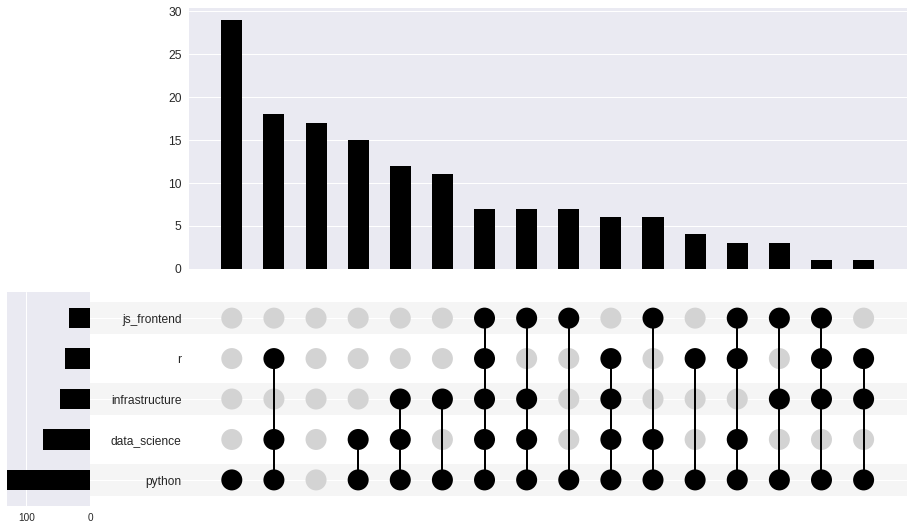

In [10]:

keep_categories = ["r", "python", "data_science", "infrastructure", "js_frontend"]
meetup_sets = (
    pandas.DataFrame(list_of_each_users_topics)[keep_categories + ["users"]]
    .fillna(False)
    .groupby(keep_categories)
    .count()
)
p = upsetplot.plot(
    meetup_sets["users"],
    element_size=60,  # point size of "side of element"
    sort_by="cardinality",
);

p['intersections'].tick_params(labelsize="medium")
p['matrix'].tick_params(labelsize="medium")
#import matplotlib
#from google.colab import files
#current_figure = matplotlib.pyplot.gcf()
#current_figure.savefig("meetup_sets.png")
#files.download("meetup_sets.png")

### Get annotation data to add as alt for visually impaired

In [12]:
meetup_sets.sort_values("users", ascending=False)["users"]

r      python  data_science  infrastructure  js_frontend
False  True    False         False           False          29
True   True    True          False           False          18
False  False   False         False           False          17
       True    True          False           False          15
                             True            False          12
               False         True            False          11
                             False           True            7
               True          True            True            7
True   True    True          True            True            7
False  True    True          False           True            6
True   True    True          True            False           6
               False         False           False           4
False  True    False         True            True            3
True   True    True          False           True            3
               False         True            False           

### Another chart; this time without the 'R' category

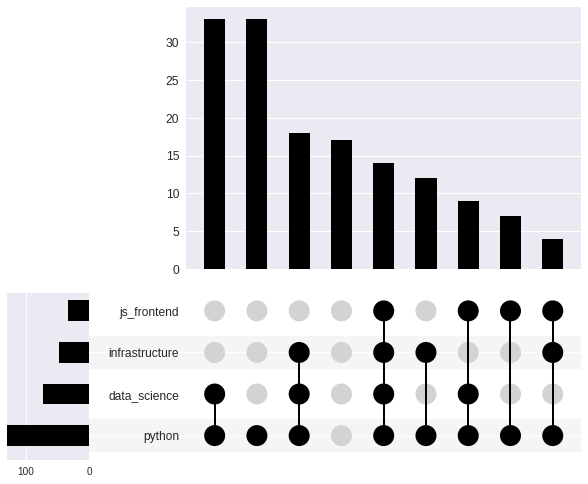

In [13]:
# Again, but without the 'r' category
keep_categories = ["python", "data_science", "infrastructure", "js_frontend"]
meetup_sets = (
    pandas.DataFrame(list_of_each_users_topics)[keep_categories + ["users"]]
    .fillna(False)
    .groupby(keep_categories)
    .count()
)
p = upsetplot.plot(
    meetup_sets["users"],
    element_size=60,  # point size of "side of element"
    sort_by="cardinality",
);

p['intersections'].tick_params(labelsize="medium")
p['matrix'].tick_params(labelsize="medium")
#import matplotlib
#from google.colab import files
#current_figure = matplotlib.pyplot.gcf()
#current_figure.savefig("meetup_sets_no_r.png")
#files.download("meetup_sets_no_r.png")

### The corresponding numbers for the above chart

In [14]:
meetup_sets.sort_values("users", ascending=False)["users"]

python  data_science  infrastructure  js_frontend
True    False         False           False          33
        True          False           False          33
                      True            False          18
False   False         False           False          17
True    True          True            True           14
        False         True            False          12
        True          False           True            9
        False         False           True            7
                      True            True            4
Name: users, dtype: int64

### I was going to use this in a D3 or Altair plot but all my attempts were ugly

In [16]:
data_for_upload = pandas.DataFrame(list_of_each_users_topics)
group_columns = [c for c in data_for_upload.columns if c != "users"]
data_for_upload[group_columns].to_csv("groups.csv", sep="|", index=False)
print(data_for_upload[group_columns].head(3))
#from google.colab import files
#files.download("groups.csv")

   business  data_science  general  hot_new  infrastructure  js_frontend  \
0     False          True    False    False           False        False   
1     False          True     True    False           False        False   
2     False          True    False     True           False        False   

   maker  other_languages  python      r  uncategorized  
0  False            False    True   True          False  
1  False             True    True   True           True  
2  False            False    True  False           True  


### The data can be uploaded to the [UpSet web UI](https://vcg.github.io/upset/?dataset=0&duration=1000&orderBy=subsetSize&grouping=groupByIntersectionSize)
This is the format they need. Seriously you can just click and upload the data from a URL so long as it's formatted right, and you can explore the data with their web tool. Cool.

**Note** this list is of users' aggregate topics not group memberships, so it isn't possible to get any interesting information about anyone from that set; I don't want to mess up anyone's life by accident or anything.

In [0]:
# Also for hosting on the UpSet webpage at caleydo.org
column_metadata = [
    {"type": "boolean", "index": i, "name": col.replace("_", " ").title()}
    for i, col in enumerate(group_columns)
]
data_description = {
	"file": "http://tanyaschlusser.github.io/slides/data/py-kind-of-town/groups.csv",
	"name": "Meetup Groups",
	"header": 0,
	"separator": "|",
	"skip": 0,
	"meta": column_metadata,
	"sets": [
		{ "format": "binary", "start": 0, "end": len(column_metadata) }
	]
}
#from google.colab import files
#with open("groups_description.json", "w") as outfile:
#    outfile.write(json.dumps(data_description, indent=2))
#files.download("groups_description.json")